# Import Libraries
Note: upload the data file into the base folder of your Google Drive

In [ ]:
# DEBUG VARIABLE
# 0 = no debug function prints
# 1 = full debug function prints
DEBUG = 1

In [ ]:
!pip install empyrical

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 KB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39778 sha256=51c7e7cd2d1c0876fb1f89ae8a8714bf60d3d3b6f0f878e1fcce901bffdf4e37
  Stored in directory: /root/.cache/pip/wheels/0d/68/bb/926065fb744e7d7cb67334cb1a9c696722abc8303e5dc9a8d0
Successfully built empyrical


In [ ]:
#NEW
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import date
from IPython.display import display

import seaborn as sns
import itertools
import scipy.stats as sp
from sklearn.linear_model import LinearRegression
# import seaborn as sns

plt.rcParams["figure.figsize"] = (10,8)

#For UI
import ipywidgets as widgets
import panel as pn
pn.extension()

#For backtest performance metrics
from empyrical import max_drawdown, sharpe_ratio, calmar_ratio, sortino_ratio

# Functions - ETL and Basics

## Functions - Data Cleaning

In [ ]:
def import_clean_df(excel_name=None, sheet_name=None, df_input=None):
    '''
    inputs:
    a) Excel data based on provided Bloomberg extract format (same folder as notebook)
    b) dataframe (for Google Colab environment)
    output: DF for downsteam manipulation
    '''
    # dataframe input
    if type(df_input) == pd.DataFrame:
      df = df_input
      print("Selected input method: provided DataFrame") if DEBUG else None

    # assumes excel given (and df is None)
    elif excel_name is not None:
      if sheet_name is None:
          sheet_name = 0
      df = pd.read_excel(io=excel_name,sheet_name=sheet_name)
      print("Selected input method: provided Excel") if DEBUG else None

    else:  # none are provided!
      print("No valid input was provided!") if DEBUG else None
      return -1


    # Set dates as df index
    df.set_index(df.columns[0], inplace=True)

    print(f"\nBefore dropping NaN: {df.shape}") if DEBUG else None
    n_rows = df.shape[0]

    # As discussed, dropping all rows with existing NA's in some of the data
    df.dropna(axis=0, how="any", inplace=True)

    n_NAN = n_rows - df.shape[0]
    if DEBUG:
      print(f"Dropped {n_NAN} rows with NAN values")
      print(f"After dropping NaN: {df.shape}")


# COMMENTED OUT TO TEST CONVEXITY ETC
    # USD IRS data is in %, so multiply by 100 to convert to bps
    # if sheet_name == "USD IRS":
    #     df = df*100

    return df

## Functions - Fly Construction

In [ ]:

def construct_fly_maturities(maturity_list):
    '''
    input: list of maturities (assumed in increasing order)
    output: list of flies, which is filtered for approved combinations
    '''
    maturity_list = sorted(maturity_list)

    fly_list = []  # empty list for storage
    n = len(maturity_list)  # number of maturities

    for i in range(n-2):
      for j in range(i+1, n-1):
        for k in range(j+1, n):
          left = maturity_list[i]
          mid = maturity_list[j]
          right = maturity_list[k]

          # wing lengths
          left_wing = mid-left
          right_wing = right-mid

          # given restrictions:
          # 1) not more than 10y gap between each wing
          # 2) right wing should be not more than 2x left wing
          if left_wing <= 10 and right_wing <= 10 and (2 * left_wing >= right_wing) and (2 * right_wing >= left_wing):
            fly_list.append((left, mid, right))
            # fly_list.append(tuple([maturity_list[i],maturity_list[j+1],maturity_list[k+2]]))

    # return sorted(set(fly_list))
    return sorted(fly_list)


'''
NOTE:
For optimization, would be better to create an appropriately-sized dataframe
with empty columns at the beginning of operations
Incrementally appending is more data intensive and leads to memory fragmentation, requiring the df=df.copy()
It would be more efficient to append all columns immediately (or create a separate df of just flies)
and then fill them in via formula
'''


def append_flies(df, fly_list):
    '''
    input: df for manipulation, tuples of fly leg maturities
    Original df column names are ints - convert them here to strings
    output: df with appended columns with fly prices
    '''

    # Convert df column names to strings
    df.columns = df.columns.astype(str)

    # Loop through all flies and concatenate to df (values in fly tuples are ints)
    for fly in fly_list:
      # Extract maturities from fly tuple; these are ints
      left = fly[0]
      mid = fly[1]
      right = fly[2]

      # Convert maturities to strings in order to access df columns
      left_str = str(left)
      mid_str = str(mid)
      right_str = str(right)

      # Construct new df fly column name from pulled maturities
      fly_name = left_str + 's' + mid_str + 's' + right_str + 's'

      # Append new fly column of prices to df
      df[fly_name] = (2*df[mid_str]) - df[left_str] - df[right_str]

      df = df.copy()

    return df


def sanity_check(df, maturities, fly_list):
    '''
    Purpose: Sanity check to make sure the correct number of columns was added to df
    Input: dataframe, raw list of maturities (int), list of flies (tuples)
    Output: 0 if good, -1 if error
    '''

    # Number of maturities in original data
    n_maturities = len(maturities)
    # Number of fly combinations
    n_flies = len(fly_list)
    # Number of columns in final df
    n_columns = len(df.columns)

    # The sum of these should add up to the number of columns in final df
    if (n_maturities+n_flies) == n_columns:
      print("Correct number of fly columns added to df.") if DEBUG == 1 else None
      return 0
    else:
      print("Something is wrong.") if DEBUG == 1 else None
      return -1


def return_fly_tuple(fly):
    '''
    Purpose: return tuple from a series or series name (ex: 1s3s5s)
    Input: series or string
    Output: fly as tuple
    '''

    if type(fly) == pd.Series:
      fly_name = fly.name

    elif type(fly) == str:
      fly_name = fly

    else:
      print("Error, invalid input")
      return -1

    fly_tup = fly_name.split("s")[:3]
    fly_tup = tuple(int(i) for i in fly_tup)

    if len(fly_tup) != 3:
      print("Error, invalid output")
      return -1

    else:
      return fly_tup



## Functions - Duration and Convexity

In [ ]:
def fly_duration(fly_input, long=True):
  '''
  inputs: fly (as series, string, or tuple)
  output: float(duration)
  '''

  print("FLY DURATION") if DEBUG == 1 else None

  if type(fly_input) == pd.Series:
    fly = return_fly_tuple(fly_input.name)

  elif type(fly_input) == str:
    fly = return_fly_tuple(fly_input)

  elif type(fly_input) == tuple:
    fly = fly_input

  else:  # input fly does not match known format
    print("Input Error")
    return -1

  left, mid, right = fly
  # maturity rates data can be considered ZCB's, for which dur = maturity
  # dur of portfolio of ZCB = sum(individual components)
  dur = 2*mid - left - right

  if not long:  # short fly -> flip sign
    dur *= -1

  if DEBUG == 1:
    print(f"input type: {type(fly_input)}, Long: {long}")
    print(f"fly: {fly}")
    print(f"left: {left}, mid: {mid}, right: {right}, dur: {dur}")
    print()

  return dur

def fly_convexity(fly_input, long=True):
    '''
    inputs: fly (as series, string, or tuple)
    output: convexity
     - if series input: series output
     - if string / tuple input: output defaults to latest available date
    '''

    print("FLY CONVEXITY") if DEBUG == 1 else None
    conv = 0  # tracks cumulative sum

    def __conv_helper(t, y):
      conv_iter = 0
      conv_iter += t*(t+1) * 1/((1+y)**2)
      return conv_iter

    if type(fly_input) == pd.Series:
      fly = return_fly_tuple(fly_input.name)
      left = df[str(fly[0])]
      mid = df[str(fly[1])]
      right = df[str(fly[2])]

      conv = 2 * __conv_helper(fly[1], mid)
      - __conv_helper(fly[0], left)
      - __conv_helper(fly[2], right)

    elif type(fly_input) == str:
      fly = return_fly_tuple(fly_input)

      # ASSUMES LATEST DATE AVAILABLE FOR CONVEXITY
      left = df[str(fly[0])][-1]
      mid = df[str(fly[1])][-1]
      right = df[str(fly[2])][-1]

      conv = 2 * __conv_helper(fly[1], mid)
      - __conv_helper(fly[0], left)
      - __conv_helper(fly[2], right)

    elif type(fly_input) == tuple:
      fly = fly_input
      left, mid, right = fly

      # ASSUMES LATEST DATE AVAILABLE FOR CONVEXITY
      left = df[str(fly[0])][-1]
      mid = df[str(fly[1])][-1]
      right = df[str(fly[2])][-1]

      conv = 2 * __conv_helper(fly[1], mid)
      - __conv_helper(fly[0], left)
      - __conv_helper(fly[2], right)

    else:  # input fly does not match known format
      print("Input Error")
      return -1

    if not long:  # short fly -> flip sign
      conv *= -1

    if DEBUG == 1:
      print(f"input type: {type(fly_input)}, Long: {long}")
      print(f"fly: {fly}")
      print(
          f"types: left: {type(left)}, mid: {type(mid)}, right: {type(right)}")
      print(f"left: {left}, mid: {mid}, right: {right}, conv: {conv}")
      print()

    return conv


## Functions - Plotting

In [ ]:

def plot_flies(df, columns_to_graph, start_date=None, end_date=None):
    '''
    Inputs:
    dataframe, list of column names as strings,
    start date (optional) , end date (optional) in yyyy-mm-dd format
    Output: plot of data
    No explicit data manipulation is performed
    '''
    start_date = np.min(df.index) if start_date is None else datetime.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = np.max(df.index) if end_date is None else datetime.datetime.strptime(end_date, "%Y-%m-%d")

    to_plot = df.loc[start_date:end_date] * 100

    to_plot.plot(y=columns_to_graph,
                                     use_index=True,
                                     title=f"{df.index.name} {start_date:%Y-%m-%d} to {end_date:%Y-%m-%d}")


# Test Code

## Test Code - Import Data

In [ ]:
# Import code for Colab vs. local (assumes data in same folder):

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

print("IN COLAB?", IN_COLAB) if DEBUG==1 else None

if not IN_COLAB: # local python environment
    df = import_clean_df(excel_name="CMU DATA.xlsx", sheet_name="USD IRS")

else: # import syntax for Colab
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    # root directory:
    # %cd /
    df = pd.read_excel('/content/gdrive/MyDrive/CMU DATA.xlsx')
    df = import_clean_df(df_input=df)

df.tail()


## Test Code - Fly Construction

In [ ]:
#Create list of maturities from df column names
maturities = list(df.columns)

#Create list containing maturities in all possible/relevant flies
fly_list = construct_fly_maturities(maturities)

if DEBUG == 1:
    print("Number of approved fly combinations:", len(fly_list))
    print()
    print("Approved fly combinations:")
    print((fly_list))

In [ ]:
#Append fly columns to dataframe
df = append_flies(df, fly_list)

#Display df
df

In [ ]:
# test function to convert string / series name to a tuple

fly_tup = return_fly_tuple(df.iloc[:,15].name)
print("from string:", fly_tup) if DEBUG == 1 else None

fly_tup = return_fly_tuple(df.iloc[:,15])
print("from series:",fly_tup) if DEBUG == 1 else None

In [ ]:
#Sanity check
sanity_check(df,maturities,fly_list)

## Test Code - Fly Duration and Convexity

In [ ]:
# test code for duration
test_fly_tup = (10,15,25)
fly_duration(test_fly_tup)
# # print("tuple input:",test_fly_tup, fly_duration(test_fly_tup))
# print()

test_fly_series_name = df.iloc[:, 16].name
fly_duration(test_fly_series_name)

test_fly_series = df.iloc[:, 22]
fly_duration(test_fly_series)

test_fly_str = "1s5s15s"
fly_duration(test_fly_str)

fly_duration(test_fly_str,long=False)

In [ ]:
# test code for convexity
test_fly_tup = (10,15,25)
fly_convexity(test_fly_tup)
# # print("tuple input:",test_fly_tup, fly_duration(test_fly_tup))
# print()

test_fly_series_name = df.iloc[:, 16].name
fly_convexity(test_fly_series_name)

test_fly_series = df.iloc[:, 22]
fly_convexity(test_fly_series)

test_fly_str = "1s5s15s"
fly_convexity(test_fly_str)

fly_convexity(test_fly_str,long=False)

## Test Code - Plotting

In [ ]:
# should match graph in Murphy's email
plot_flies(df,["2s5s10s"],'2020-09-17','2021-09-17')

In [ ]:
plot_flies(df,["1s2s3s","1s3s4s","2s3s4s","2s3s5s"],'2020-09-17','2021-09-17') # additional examples

# Functions - Signals

In [ ]:
# %cd /

In [ ]:
import pandas as pd
import numpy as np
import itertools
from datetime import date
import scipy.stats as sp
from sklearn.linear_model import LinearRegression
# import seaborn as sns

class Wing_Backtester:

  def __init__(self):
      self.df = self.build_df()
      self.butterflies = self.generate_feasible_flys()
      self.n = len(self.df)

  #INPUT: Excel data based on provided Bloomberg extract format (same folder as notebook)
  #OUTPUT: DF for downsteam manipulation
  def build_df(self):
      df = pd.read_excel('/content/gdrive/MyDrive/CMU DATA.xlsx', index_col=0)
      init_row = df.shape[0]

      print("Row count: ",init_row)

      # As discussed, dropping all rows with existing NA's in some of the data
      df.dropna(axis=0,how="any",inplace=True)

      print("Dropped",init_row-df.shape[0], "rows")
      print("Row count: ",df.shape[0], "\n")

      return df*100

  # all possible butterfly trades where wings of butterfly strat are within 10 years of center
  # not being used?
  def generate_feasible_flys(self):
      butterflies = []
      for comb in itertools.combinations(self.df.columns, 3):
          left_wing, middle, right_wing = comb[0],comb[1],comb[2]
          if left_wing-middle <=10 and middle-right_wing <= 10:
              if (left_wing-middle)*2 <= (middle-right_wing) and (left_wing-middle) >= (middle-right_wing)*2:
                  butterflies.append(comb)

      return butterflies

  def generate_range_trade_signal(self, strat, weights=None,start_idx=0, end_idx=None):
      if weights == None:
          weights = 0.4, 0.3, 0.3
      if end_idx == None:
          end_idx = self.n -1

      left_wing = self.df.loc[:,strat[0]]
      middle = self.df.loc[:,strat[1]]
      right_wing = self.df.loc[:,strat[2]]

      fly = -left_wing + 2 * middle - right_wing
      curve_cost =  right_wing - left_wing
      level_cost = middle
      correlation1 = np.corrcoef(curve_cost.values, fly.values)[0][1]
      correlation2 = np.corrcoef(level_cost.values, fly.values)[0][1]

      # make sure fly has no correlation to it's curvature
      if correlation1 > 0.75:
        print('Correlation with curve is',correlation1,', this trade is not a range trade')
      if correlation2 > 0.75:
        print('Correlation with level is',correlation2,', this trade is not a range trade')
        #return None

      # we can assume 252 trading days in a year, start from the index 3*252
      z = {}
      for i in range(start_idx+3*252,end_idx+1):
          date, cost = fly.index[i], fly.iloc[i]
          df1y = fly[i-252:i]
          z1y = (cost - df1y.mean())/df1y.std()
          df2y = fly[i-252*2:i]
          z2y = (cost - df2y.mean())/df2y.std()
          df3y = fly[i-252*3:i]
          z3y = (cost - df3y.mean())/df3y.std()

          z[date] = weights[0]*z1y + weights[1]*z2y + weights[2]*z3y
      return pd.Series(z,index=z.keys())

  def generate_curve_trade_signal(self, strat, weights=None,start_idx=0, end_idx=None):
      if weights == None:
          weights = 0.4, 0.3, 0.3
      if end_idx == None:
          end_idx = self.n -1

      left_wing = self.df.loc[:,strat[0]]
      middle = self.df.loc[:,strat[1]]
      right_wing = self.df.loc[:,strat[2]]

      fly_cost = -left_wing + 2 * middle - right_wing
      curve_cost =  right_wing - left_wing

      correlation = np.corrcoef(curve_cost.values, fly_cost.values)[0][1]

      if correlation < 0.75 :
        print('Correlation with curve is',correlation,', this trade is not a curve trade')
      # we can assume 252 trading days in a year, start from the index 3*252
      z = {}
      beta = {}
      for i in range(start_idx+3*252,end_idx+1):
          date, cost = fly_cost.index[i], fly_cost.iloc[i]
          z_score = []
          beta[date] = 0
          for year in [1,2,3] :
            df1y = fly_cost[i-252*year:i].values
            dcurve = curve_cost[i-252*year:i].values.reshape(-1,1)
            reg = LinearRegression().fit(dcurve, df1y)
            beta[date] += weights[year - 1]*reg.coef_[0]

            y_hat = reg.predict(dcurve)
            y = df1y
            residual = y - y_hat
            sigma = np.sqrt(np.var(residual))
            ith_residual= cost - reg.predict(np.array(curve_cost[i]).reshape(1, -1))[0]
            z_score.append(ith_residual/sigma)

          z[date] = weights[0]*z_score[0] + weights[1]*z_score[1] + weights[2]*z_score[2]

      return pd.Series(z,index=z.keys()),pd.Series(beta,index=beta.keys())

  def generate_level_trade_signal(self, strat, weights=None,start_idx=0, end_idx=None):
      if weights == None:
          weights = 0.4, 0.3, 0.3
      if end_idx == None:
          end_idx = self.n -1

      left_wing = self.df.loc[:,strat[0]]
      middle = self.df.loc[:,strat[1]]
      right_wing = self.df.loc[:,strat[2]]

      level_cost = middle
      fly_cost = -left_wing + 2 * middle - right_wing
      curve_cost =  right_wing - left_wing

      correlation = np.corrcoef(level_cost.values, fly_cost.values)[0][1]

      if correlation < 0.75 :
        print('Correlation with level is',correlation,', this trade is not a level trade')
      # we can assume 252 trading days in a year, start from the index 3*252
      z = {}
      beta = {}
      for i in range(start_idx+3*252,end_idx+1):
          date, cost = fly_cost.index[i], fly_cost.iloc[i]
          z_score = []
          beta[date] = 0
          for year in [1,2,3] :
            df1y = fly_cost[i-252*year:i].values
            dlevel = level_cost[i-252*year:i].values.reshape(-1,1)
            reg = LinearRegression().fit(dlevel, df1y)
            beta[date] += weights[year - 1]*reg.coef_[0]
            y_hat = reg.predict(dlevel)
            y = df1y
            residual = y - y_hat
            sigma = np.sqrt(np.var(residual))
            ith_residual=cost-reg.predict(np.array(level_cost[i]).reshape(1, -1))[0]
            z_score.append(ith_residual/sigma)

          z[date] = weights[0]*z_score[0] + weights[1]*z_score[1] + weights[2]*z_score[2]

      return pd.Series(z,index=z.keys()),pd.Series(beta,index=beta.keys())

#************************** simple signal backtesting engine for signals **************************
  def simple_signal_backtest(self, strat, trade_type, weights = (0.4, 0.3, 0.3),threshold = 1.5,
                             start_date=None, end_date=None):

      start_date = np.min(self.df.index) if start_date is None else datetime.datetime.strptime(start_date,"%Y-%m-%d")
      end_date = np.max(self.df.index) if end_date is None else datetime.datetime.strptime(end_date,"%Y-%m-%d")
      start_idx = self.df.index.get_loc(start_date)
      end_idx = self.df.index.get_loc(end_date)

      left_wing = self.df.loc[:,strat[0]]
      middle = self.df.loc[:,strat[1]]
      right_wing = self.df.loc[:,strat[2]]

      fly_cost = - left_wing + 2 * middle - right_wing
      curve_cost =  right_wing - left_wing
      level_cost =  middle

      if trade_type == 'range':
          signal = self.generate_range_trade_signal(strat,weights,start_idx,end_idx)
          underlying = fly_cost.iloc[start_idx+3*252:end_idx+1]

      # as Murphy stated in his email, we need to discuss how should we trade curve and range spread
      elif trade_type == 'curve':
          signal, beta = self.generate_curve_trade_signal(strat,weights,start_idx,end_idx)
          underlying = (fly_cost - beta*curve_cost).iloc[start_idx+3*252:end_idx+1]
      elif trade_type == 'level':
          signal,beta = self.generate_level_trade_signal(strat,weights,start_idx,end_idx)
          underlying = (fly_cost - beta*level_cost).iloc[start_idx+3*252:end_idx+1]

      # trading rule: buy or sell 1 unit underlying whenever signal reaches threshold
      #
      # you can change this part of code to test whatever trading rules you wanna check

      buy_or_sell = [-1 if score >= threshold else 1 if score <= -threshold else 0 for score in signal]
      positions = np.cumsum(buy_or_sell)

      #calculate pnl
      unrlzd = np.cumsum(np.multiply(np.diff(underlying),positions[1:]))

      # an video explaining the calculation of realized and unrealized pnl
      # https://aaaquants.medium.com/how-to-calculate-profit-and-loss-p-ls-for-your-trading-strategies-python-for-financial-analysis-461f9206ce84

      return  pd.Series(unrlzd,index=signal[1:].keys())

  def onexth_signal_backtest(self, strat, trade_type, weights = (0.4, 0.3, 0.3),threshold = 1.5,exit_threshold = 0.3,
                             stop_loss_threshold = 2.7, trade_times = 3, holding_time = 20 ,start_date=None, end_date=None):

      start_date = np.min(self.df.index) if start_date is None else datetime.datetime.strptime(start_date,"%Y-%m-%d")
      end_date = np.max(self.df.index) if end_date is None else datetime.datetime.strptime(end_date,"%Y-%m-%d")
      start_idx = self.df.index.get_loc(start_date)
      end_idx = self.df.index.get_loc(end_date)

      left_wing = self.df.loc[:,strat[0]]
      middle = self.df.loc[:,strat[1]]
      right_wing = self.df.loc[:,strat[2]]

      fly_cost = - left_wing + 2 * middle - right_wing
      curve_cost =  right_wing - left_wing
      level_cost =  middle

      fly = fly_cost.iloc[start_idx+3*252:end_idx+1]
      if trade_type == 'range':
          signal = self.generate_range_trade_signal(strat,weights,start_idx,end_idx)
          beta, hedging_instrm = np.zeros(len(fly)), np.zeros(len(fly))

      elif trade_type == 'curve':
          signal, beta = self.generate_curve_trade_signal(strat,weights,start_idx,end_idx)
          hedging_instrm = curve_cost.iloc[start_idx+3*252:end_idx+1]

      elif trade_type == 'level':
          signal,beta = self.generate_level_trade_signal(strat,weights,start_idx,end_idx)
          hedging_instrm = level_cost.iloc[start_idx+3*252:end_idx+1]

      # trading rule: each time the signal reaches the threshold,
      # buy 1/trade_times * capital of underlying until the pct_invest reaches 1*capital
      # exit trade when signal reaches stop loss threshold or exit threshold
      # or when holding days exceed holding_time

      df = pd.DataFrame(signal,columns=['signal'])
      df['long'] = df['signal'] <= -threshold
      df['short'] = df['signal'] >= threshold
      df['exit'] = (np.abs(df['signal'])<= exit_threshold)|(np.abs(df['signal'])>=stop_loss_threshold)
      df['positions'] = 0
      df['positions_hedge'] = 0

      pos = 0
      pos_hedge = 0
      days = 0
      for i in range(len(df)):
          if df['long'][i]:
            pos = min(pos+1,trade_times)
            days += 1
          if df['short'][i]:
            pos = max(pos-1,-trade_times)
            days += 1
          if df['exit'][i]:
            pos = 0
            days = 0

          if days >= holding_time: pos = 0; days = 0
          df.iloc[i,-2] = pos/trade_times

          # rebalance the hedging intrument only when fly position changes
          if i>=1:
              if df.iloc[i,-2]!=df.iloc[i-1,-2]: pos_hedge = -df.iloc[i,-2]*beta[i]
          df.iloc[i,-1] = pos_hedge
      #calculate unrealized pnl
      unrlzd = np.cumsum(np.multiply(np.diff(fly),df.positions[1:]) + np.multiply(np.diff(hedging_instrm),df.positions_hedge[1:]))
      return unrlzd


  #simple strat of entering butterfly at earliest time and closing at last date
  def simple_backtest(self, strat, wing_long=True):
      left_wing = self.df.loc[:,strat[0]]
      middle = self.df.loc[:,strat[1]]
      right_wing = self.df.loc[:,strat[2]]

      cost = left_wing[0] - 2 * middle[0] + right_wing[0]
      profit = left_wing[-1] - 2 * middle[-1] + right_wing[-1]

      if wing_long == False:
          cost *= -1
          profit *= -1

      return profit - cost

  #find dates to enter/exit which result in highest return on a certain butterfly trade
  def maximum_return(self, strat, wing_long=True):
      butterfly = self.df.loc[:,strat[0]] - 2 * self.df.loc[:,strat[1]] + self.df.loc[:,strat[2]]

      if wing_long == False:
          butterfly *= -1

      enter_date, exit_date = None, None
      max_profit, min_price = 0, float('inf')

      for i in range(len(butterfly)):
          if butterfly[i] < min_price:
              enter_date = self.df.index[i]
              min_price = butterfly[i]

          profit = butterfly[i] - min_price

          if max_profit < profit:
              exit_date = self.df.index[i]
              max_profit = profit

      return max_profit, enter_date.strftime("%d/%m/%y"), exit_date.strftime("%d/%m/%y")

  #backtest where we long wing and short middle
  def test_long_wing(self):
      long_wing = {"Strat":[] ,"Buy Hold Profit":[], "Max Profit":[], "Enter Time":[], "Exit Time":[]}
      for strat in self.butterflies:
          buy_hold = self.simple_backtest(strat, True)
          max_profit, enter_time, exit_time = self.maximum_return(strat, True)
          long_wing["Strat"].append(strat)
          long_wing["Buy Hold Profit"].append(buy_hold)
          long_wing["Max Profit"].append(max_profit)
          long_wing["Enter Time"].append(enter_time)
          long_wing["Exit Time"].append(exit_time)

      return pd.DataFrame(long_wing)

  #backtest where we short wing and long middle
  def test_short_wing(self):
      short_wing = {"Strat":[] ,"Buy Hold Profit":[], "Max Profit":[], "Enter Time":[], "Exit Time":[]}
      for strat in self.butterflies:
          buy_hold = self.simple_backtest(strat, False)
          max_profit, enter_time, exit_time = self.maximum_return(strat, False)
          short_wing["Strat"].append(strat)
          short_wing["Buy Hold Profit"].append(buy_hold)
          short_wing["Max Profit"].append(max_profit)
          short_wing["Enter Time"].append(enter_time)
          short_wing["Exit Time"].append(exit_time)

      return pd.DataFrame(short_wing)

  #INPUT: dataframe, list of column names as strings, start date (optional) , end date (optional) in yyyy-mm-dd format
  #OUTPUT: plot of data; no explicit data manipulation (const)
  def plot_flies(self,left, center, right,start_date=None,end_date=None):
      start_date = np.min(self.df.index) if start_date is None else datetime.datetime.strptime(start_date,"%Y-%m-%d")
      end_date = np.max(self.df.index) if end_date is None else datetime.datetime.strptime(end_date,"%Y-%m-%d")

      butterfly = self.df.loc[start_date:end_date,left] - 2 * \
                  self.df.loc[start_date:end_date,center] + self.df.loc[start_date:end_date,right]
      butterfly.plot(use_index=True, title = f"{self.df.index.name} {start_date:%Y-%m-%d} to {end_date:%Y-%m-%d}")

  def plot_fly_curve(self,left,center,right,start_date=None,end_date=None ):
      # goal: replicate fly curve plots
      start_date = np.min(self.df.index) if start_date is None else datetime.datetime.strptime(start_date,"%Y-%m-%d")
      end_date = np.max(self.df.index) if end_date is None else datetime.datetime.strptime(end_date,"%Y-%m-%d")

      butterfly = -self.df.loc[start_date:end_date,left] + 2 * \
                  self.df.loc[start_date:end_date,center] - self.df.loc[start_date:end_date,right]
      curve = self.df.loc[start_date:end_date,right] - self.df.loc[start_date:end_date,left]
      butterfly.plot(use_index=True, title = f"{self.df.index.name} {start_date:%Y-%m-%d} to {end_date:%Y-%m-%d}",label='fly')
      curve.plot(label='curve')
      plt.legend()
      plt.show()
      return butterfly, curve

  def plot_fly_level(self,left,center,right,start_date=None,end_date=None ):
      start_date = np.min(self.df.index) if start_date is None else datetime.datetime.strptime(start_date,"%Y-%m-%d")
      end_date = np.max(self.df.index) if end_date is None else datetime.datetime.strptime(end_date,"%Y-%m-%d")

      butterfly = -self.df.loc[start_date:end_date,left]+ 2 * \
                   self.df.loc[start_date:end_date,center] - self.df.loc[start_date:end_date,right]
      level = self.df.loc[start_date:end_date,center]

      butterfly.plot(use_index=True, title = f"{self.df.index.name} {start_date:%Y-%m-%d} to {end_date:%Y-%m-%d}",label='fly')
      level.plot(label = 'level')
      plt.legend()
      plt.show()
      return butterfly, level


  #User Interface section
  def initialize_interface(self):
    self.strat = widgets.SelectMultiple(
      options=['Range trade', 'Curve trade', 'LEVEL trade', 'Custom Strategy'],
      value=['Range trade'],
      rows=4,
      description='Strategy',
      disabled=False
      )

    self.metrics = pn.widgets.CheckBoxGroup(
     name='Checkbox Group',
     value=['Sharpe Ratio', 'VaR (95%)', 'CVaR (95%)'],
     options=['Sharpe Ratio', 'VaR (95%)', 'CVaR (95%)', 'Drawdown', 'Calmar Ratio', 'Sortino Ratio'],
     inline=False)

    vals = list(self.df.columns)
    self.left_wing = pn.widgets.DiscreteSlider(name='Left Wing', options=vals, value=vals[0])
    self.right_wing = pn.widgets.DiscreteSlider(name='Right Wing', options=vals, value=vals[-1])


  def pick_strategy(self):
      return self.strat

  def pick_metrics(self):
      return self.metrics

  def pick_left_wing(self):
      return self.left_wing

  def pick_right_wing(self):
      return self.right_wing

  def pick_middle(self):
      vals = list(self.df.columns)
      left = vals.index(self.left_wing.value) + 1
      right = vals.index(self.right_wing.value)
      self.middle = pn.widgets.DiscreteSlider(name='Middle', options=vals[left:right], value=vals[left:right][0])
      return self.middle

  def pick_threshold_and_times(self):
      text_width = widgets.Layout(width='130px')
      text2_width = widgets.Layout(width='100px')
      drop_width = widgets.Layout(width='80px')

      self.threshold = widgets.FloatText(value=1.5, step=.1, layout=drop_width)
      self.exit_threshold =widgets.FloatText(value=0.3, step=.1, layout=drop_width)
      self.stop_loss_threshold = widgets.FloatText(value=2.7, step=.1, layout=drop_width)

      self.trade_times = widgets.IntText(value=3, layout=drop_width)
      self.holding_time = widgets.IntText(value=20, layout=drop_width)

      h_threshold = widgets.HBox([widgets.Label('Threshold:', layout=text_width), self.threshold])
      h_exit_threshold = widgets.HBox([widgets.Label('Exit threshold:', layout=text_width), self.exit_threshold])
      h_stop_loss_threshold = widgets.HBox([widgets.Label('Stop loss threshold:', layout=text_width), self.stop_loss_threshold ])
      h_trade_times = widgets.HBox([widgets.Label('Trade times:', layout=text2_width), self.trade_times])
      h_holding_time = widgets.HBox([widgets.Label('Holding times:', layout=text2_width), self.holding_time])

      left_box = widgets.VBox([h_threshold, h_exit_threshold, h_stop_loss_threshold])
      right_box = widgets.VBox([h_trade_times, h_holding_time])
      box = widgets.HBox([left_box, right_box])
      return box

  def run_backtest(self):
    if (self.left_wing.value-self.middle.value)*2 > (self.middle.value-self.right_wing.value) or (self.left_wing.value-self.middle.value) < (self.middle.value-self.right_wing.value)*2:
      return "Error: Unbalanced wings. Rerun past three code blocks and make sure one wing isn't twice as long other wing."
    else:
      type_dict= {'Range trade':'range', 'Curve trade':'curve', 'LEVEL trade':'level'}
      metric_dict = {'Drawdown': drawdown, 'VaR (95%)': var, 'CVaR (95%)': cvar ,'Sharpe Ratio': sharpe_ratio,  'Calmar Ratio': calmar_ratio, 'Sortino Ratio': sortino_ratio}

      self.pnl = pd.DataFrame()
      output = {metric:[] for metric in self.metrics.value}

      for trade_type in self.strat.value:
        strat = (self.left_wing.value, self.middle.value, self.right_wing.value)
        temp_pnl = self.onexth_signal_backtest(strat, type_dict[trade_type], threshold = self.threshold.value ,exit_threshold = self.exit_threshold.value,
                             stop_loss_threshold = self.stop_loss_threshold.value, trade_times = self.trade_times.value, holding_time = self.holding_time.value)

        temp_pnl.name = trade_type
        self.pnl[trade_type] = temp_pnl

        for metric in self.metrics.value:
          output[metric].append(metric_dict[metric](temp_pnl))

      df_metric = pd.DataFrame(output)
      df_metric.index = self.strat.value

      return self.pnl, df_metric


#helper function to calculate metric
def drawdown(pnl):
  return pnl[-1] - max(pnl)

def var(pnl, r=95):
  pnl_val = pnl.values.flatten()
  return np.percentile(pnl_val,100-r)

def cvar(pnl, r=95):
  pnl_val = pnl.values.flatten()
  return np.mean(pnl_val[pnl_val < np.percentile(pnl_val,100-r)])




# Test Code - Signals

In [ ]:
wa = Wing_Backtester()

In [ ]:
wa.test_long_wing()

In [ ]:
wa.plot_flies(1,2,3)

In [ ]:
# params for presentation slide pictures
params = {
    "axes.titlecolor": "w",
    "ytick.color" : "w",
    "xtick.color" : "w",
    "axes.labelcolor" : "w",
    "axes.edgecolor" : "w"}
plt.rcParams.update(params)

butterfly, curve = wa.plot_fly_curve(3,5,7)
y = butterfly.values
x = curve.values

# params for presentation slide pictures
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

plt.figure(figsize=(6,6))
plt.scatter(x,y)
m, b = np.polyfit(x, y, 1)
correlation = np.corrcoef(x, y)[0,1]
print("corr : {:.3f}".format(correlation))
print("r2 : {:.3f}".format(correlation**2))
print("y = {:.3f}x {:.3f}".format(m, b))
plt.plot(x,m*x+b, color="blue")
plt.scatter(x,y)
plt.ylabel("y = butterfly with IRS 3y, 5y, 7y")
plt.xlabel("x = curve with IRS 3y, 7y")
plt.show()


default_params = {
          "axes.titlecolor": "black",
          "ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black"}
plt.rcParams.update(default_params)

In [ ]:
# params for presentation slide pictures
params = {
    "axes.titlecolor": "w",
    "ytick.color" : "w",
    "xtick.color" : "w",
    "axes.labelcolor" : "w",
    "axes.edgecolor" : "w"}
plt.rcParams.update(params)


butterfly, level = wa.plot_fly_level(2,5,10, start_date='2020-09-17')
wa.plot_fly_level(2,5,10)

y = butterfly.values
x = level.values
plt.figure(figsize=(6,6))
plt.scatter(x,y)
m, b = np.polyfit(x, y, 1)
correlation = np.corrcoef(x, y)[0,1]
print("corr : {:.3f}".format(correlation))
print("r2 : {:.3f}".format(correlation**2))
print("y = {:.3f}x {:.3f}".format(m, b))
plt.plot(x,m*x+b, color="blue")
plt.scatter(x,y)
plt.ylabel("y = butterfly with IRS 2y, 5y, 10y")
plt.xlabel("x = level with IRS 5y")
plt.show()

default_params = {
          "axes.titlecolor": "black",
          "ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black"}
plt.rcParams.update(default_params)

In [ ]:
# range trade weighted z-score
z_range = wa.generate_range_trade_signal((8,10,12))
z_range.plot()
threshold = 1.5
plt.hlines(threshold, xmin = z_range.index[0], xmax = z_range.index[-1], linestyles='dashed',color='r')
plt.hlines(-threshold, xmin = z_range.index[0], xmax = z_range.index[-1], linestyles='dashed',color='r')
plt.title('Range Trade Example')
plt.show()

In [ ]:
# curve trade z-score
z_curve = wa.generate_curve_trade_signal((3,5,7))[0]
z_curve.plot()
threshold = 1.5
plt.hlines(threshold, xmin = z_curve.index[0], xmax = z_curve.index[-1], linestyles='dashed',color='r')
plt.hlines(-threshold, xmin = z_curve.index[0], xmax = z_curve.index[-1], linestyles='dashed',color='r')
plt.title('Curve Trade Example')
plt.show()

In [ ]:
# level trade z-score
z_level = wa.generate_level_trade_signal((3,5,7))[0]
z_level.plot()
threshold = 1.5
plt.hlines(threshold, xmin = z_level.index[0], xmax = z_level.index[-1], linestyles='dashed',color='r')
plt.hlines(-threshold, xmin = z_level.index[0], xmax = z_level.index[-1], linestyles='dashed',color='r')
plt.title('Level Trade Example')
plt.show()

In [ ]:
strat = (8,10,12)
pnl = wa.simple_signal_backtest(strat, 'curve')
pnl.plot(label = 'PnL',c='g')
plt.legend()
plt.show()

In [ ]:
pnl = wa.onexth_signal_backtest(strat, 'curve',trade_times=1)
pnl.plot(label = 'PnL',c='g')
plt.legend()
plt.show()

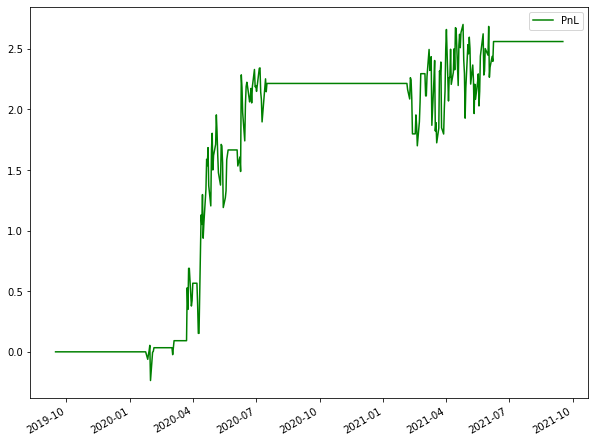

In [ ]:
pnl = wa.onexth_signal_backtest(strat, 'curve',trade_times=3)
pnl.plot(label = 'PnL',c='g')
plt.legend()
plt.show()

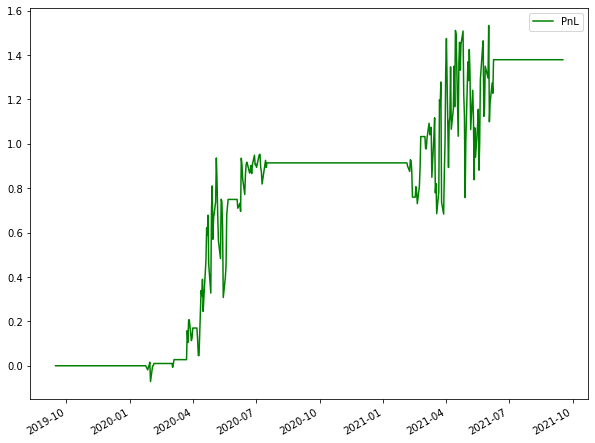

In [ ]:
pnl = wa.onexth_signal_backtest(strat, 'curve',trade_times=10)
pnl.plot(label = 'PnL',c='g')
plt.legend()
plt.show()

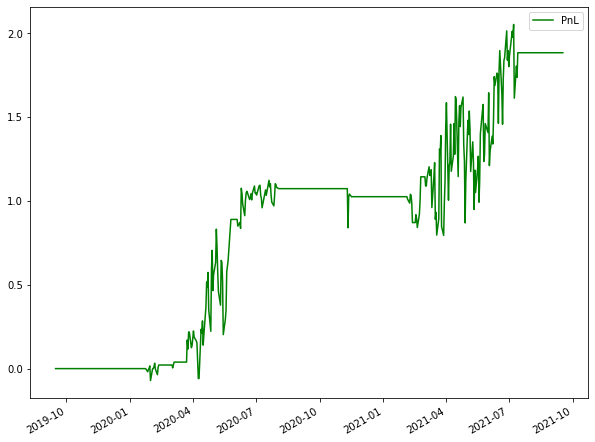

In [ ]:
pnl = wa.onexth_signal_backtest(strat, 'curve',trade_times=10,exit_threshold=0.1,stop_loss_threshold=2.8)
pnl.plot(label = 'PnL',c='g')
plt.legend()
plt.show()

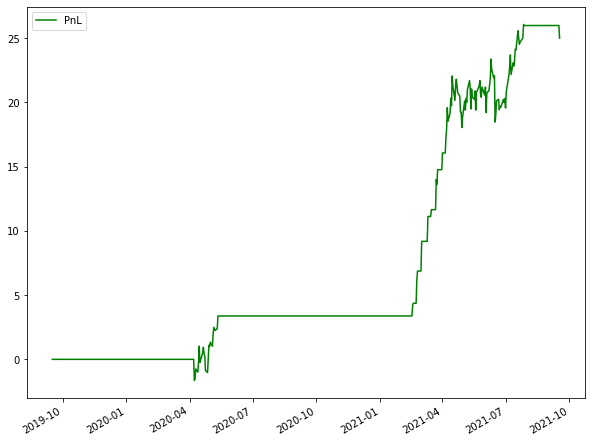

In [ ]:
pnl = wa.onexth_signal_backtest((4,9,15), 'curve',threshold = 1.9, exit_threshold = 0.3, stop_loss_threshold=2.6,trade_times = 1,holding_time = 5)
pnl.plot(label = 'PnL',c='g')
plt.legend()
plt.show()

# Technical Indicators

In [ ]:
df.iloc[:5,14:20]
ts = df["1s3s7s"]
# ts.tail()
ts.name

data = ts

In [ ]:
# input: series
# output: technical indicator

def MACD(data):
    # https://www.alpharithms.com/calculate-macd-python-272222/
    exp1 = data.ewm(span=12, adjust=False).mean()
    exp2 = data.ewm(span=26, adjust=False).mean()
    macd_slow = exp1-exp2  # MACD slow signal line
    # MACD fast signal line
    macd_signal = macd_slow.ewm(span=9, adjust=False).mean()
    macd_trigger = macd_slow-macd_signal

    macd_slow.name = data.name+"_macd_slow"
    macd_signal.name = data.name+"_macd_signal"
    macd_trigger.name = data.name+"_macd_trigger"

    return macd_trigger, macd_slow, macd_signal


def SMA(data, n=20):
    # simple moving average
    SMA = pd.Series(data.rolling(window=n).mean())
    SMA.name = data.name+"_SMA_n="+str(n)
    return SMA


def Momentum(data, n=1):
    Momentum = pd.Series(data.diff(periods=n))
    Momentum.name = data.name+"_Momentum_n="+str(n)
    return Momentum


def StochKD(data, n=20):
    StochK = (
        100
        * (data-data.rolling(window=n).min())
        / (data.rolling(window=n).max() - data.rolling(window=n).min()))

    StochD = StochK.rolling(window=n).mean()

    StochK.name = data.name+"_StochK_n="+str(n)
    StochD.name = data.name+"_StochD_n="+str(n)

    if (StochK.isna().sum() == len(data)):
        print(f"Warning: stoch indicators do not exist for n = {n}.")

    return StochK, StochD


def RSI(data, n=20):
    # https://medium.com/codex/algorithmic-trading-with-relative-strength-index-in-python-d969cf22dd85
    # https://www.roelpeters.be/many-ways-to-calculate-the-rsi-in-python-pandas/

    price_chg = data.diff()

    up = price_chg.clip(lower=0)
    dn = -1 * price_chg.clip(upper=0)

    ma_up = up.ewm(com=n - 1, adjust=True, min_periods=n).mean()
    ma_dn = dn.ewm(com=n - 1, adjust=True, min_periods=n).mean()

    rsi = ma_up / ma_dn
    # rsi = 100 - (100/(1 + rsi))
    rsi.name=data.name+"_RSI_n="+str(n)

    return rsi


def Larry_WilliamsR(data, n=20):
    # https://www.investopedia.com/terms/w/williamsr.asp
    LR = np.zeros(len(data))
    k = n-1

    HH = data.rolling(window=n).max()
    LL = data.rolling(window=n).min()
    C = data

    LR = (HH-C)/(HH-LL)*100

    LR_series = pd.Series(LR, name=data.name+"_LWR_n="+str(n))
    return LR_series
    # data['LarryWilliamsR'].iloc[:k] = data['LarryWilliamsR'].iloc[:k].replace({0: np.nan})


def Accum_Dist(data, n=20):
    # https://www.metatrader4.com/en/trading-platform/help/analytics/tech_indicators/accumulation_distribution
    H = data.rolling(window=n).max()
    L = data.rolling(window=n).min()
    C = data
    AD = (H-C)/(H-L)*100
    AD.name = data.name+"_AD_n="+str(n)

    return AD


def CCI(data, n=20):
    # https://www.investopedia.com/articles/active-trading/031914/how-traders-can-utilize-cci-commodity-channel-index-trade-stock-trends.asp
    diff = data - SMA(data, n)
    mean_dev = np.abs(diff).rolling(window=n).mean()
    CCI = diff/(mean_dev)

    CCI.name = data.name+"_CCI_n="+str(n)
    return CCI


def boll_bands(data, n=20, sd=1.645):
    sma = SMA(data, n)
    std = data.rolling(n).std()
    boll_up = sma+std*2
    boll_dn = sma-std*2
    boll_up.name = data.name+"_BollUp_n="+str(n)
    boll_dn.name = data.name+"_BollDn_n="+str(n)

    boll_up_sig = data - (sma+std*2)
    boll_dn_sig = (sma-std*2) - data

    boll_up_sig.name = data.name+"_BollUpSignal_n="+str(n)
    boll_dn_sig.name = data.name+"_BollDnSignal_n="+str(n)

    return boll_up_sig, boll_dn_sig, boll_up, boll_dn


In [ ]:
def indicators(data, n=20):
    # scaler = StandardScaler()

    # macd_trigger, macd_slow, macd_signal = MACD(data) # set lengths of 12, 26, 9
    macd_trigger, _, _ = MACD(data)  # set lengths of 12, 26, 9

    df_ind = pd.DataFrame(macd_trigger)

    sma = SMA(data, n)
    # wma = WMA(data, n)
    mom = Momentum(data, n)
    stochk, stochd = StochKD(data, n)  # returns two series
    _, stochd = StochKD(data, n)  # returns two series (stochk is volatile)
    rsi = RSI(data, n)
    lwr = Larry_WilliamsR(data, n)
    ad = Accum_Dist(data,n)
    cci = CCI(data, n)
    boll_up_sig, boll_dn_sig, boll_up, boll_dn = boll_bands(data, n)

    cols = [sma, mom, stochd, lwr, cci]

    # normalize all indicators except bollingers and scaled indicators (RSI, AD)
    # for c in cols:
    #     c = c-np.mean(c)/np.std(c)

    df_ind = pd.concat([data,boll_up,boll_dn, df_ind,sma,mom,stochd,rsi,lwr,cci,ad,rsi],axis=1)

    # df_ind = df_ind.copy(deep=True)

    return df_ind


In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('date')
ax1.set_ylabel(f'fly {df_ind.columns[0]}', color=color)
ax1.plot(df_ind.iloc[-255:,0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

for i in range(1,3):

    color = 'tab:red'
    ax2.set_ylabel(f'{df_ind.columns[i]}', color=color)
    ax2.plot(df_ind.iloc[-255:,i], color=color)
    ax2.plot(df_ind.iloc[-255:,i], color=color)

    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()

plt.show()


In [ ]:
for i in range(3,len(df_ind.columns)):
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('date')
    ax1.set_ylabel(f'fly {df_ind.columns[0]}', color=color)
    ax1.plot(df_ind.iloc[-255:,0], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel(f'{df_ind.columns[i]}', color=color)
    ax2.plot(df_ind.iloc[-255:,i], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()

    plt.show()


# User Interface

In [ ]:
wa.initialize_interface()

In [ ]:
wa.pick_strategy()

SelectMultiple(description='Strategy', index=(0,), options=('Range trade', 'Curve trade', 'LEVEL trade', 'Cust…

In [ ]:
wa.pick_metrics()

CheckBoxGroup(name='Checkbox Group', options=['Sharpe Ratio', ...], value=['Sharpe Ratio', ...])

In [ ]:
wa.pick_left_wing()

DiscreteSlider(formatter='%d', name='Left Wing', options=[1, 2, 3, 4, 5, ...], value=5)

In [ ]:
wa.pick_right_wing()

DiscreteSlider(formatter='%d', name='Right Wing', options=[1, 2, 3, 4, 5, ...], value=10)

In [ ]:
wa.pick_middle()

DiscreteSlider(formatter='%d', name='Middle', options=[6, 7, 8, 9], value=6)

In [ ]:
wa.pick_threshold_and_times()

In [ ]:
pnl, metric = wa.run_backtest()

Correlation with curve is 0.8752625645830513 , this trade is not a range trade


In [ ]:
pnl.tail()

,Range trade
2021-09-13,0.59
2021-09-14,0.59
2021-09-15,0.59
2021-09-16,0.59
2021-09-17,0.59


In [ ]:
metric

,VaR (95%),CVaR (95%),Drawdown
Range trade,-0.103333,-0.154211,0.0
